In [90]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import sys

# Model Input

Brand_Factor = Values ranging from ($0.1$ -> $2.9$).

There are different ways in which brand factor may behave (i.e. there is no information about its nature, thus I have to make some assumptions. I will not model all of the possibilities). Some of which are the following. 

1) Brand_Factor is some vector $\overline{v} \in \mathbb{R}^{8838}$. This is because, the file provided by Simudyna has these many policies. It is possible that the brand factor then stays the same throughout all $15$ years.

2) Brand_Factor randomly changes throught the $15$ years. So for a hypothetical policy, it may be $2.1$ in year $1$ and then (year $2$ in this case) changes with no autoregressive or any kind of relationship with respect to values in year $1$ and so on. So, the values randomly change throughout, while staying in the defined ranges, i.e. if $v_1 \in \overline{v}$ is brand_factor of some policy, then as given by the problem outline, $v_1 \in [0.1,2.9]$ always. Formally, for some $$v_i \in \overline{v}$$
we have that on any given year, $$v_i \sim U(0.1,2.9)$$
if we allow for possibility of brand factor changes.

3) Brand_Factor may be initialized to some values in year 1 and then decay.

4) Brand_Factor may be pertaining to a certain family of policies.
etc.

For simplicity, I make an assumption that brand_factor initialized is the one to be used throughout all of the years, so is constant.

# Model Run
To maximally reduce the number of redundant computations, before we perform any kind of agent-based modelling, we pre-compute and keep in memory the following:

Affinity = Payment_at_Purchase/Attribute_Price + rand $\times$ (Attribute_Promotions x Intertia_for_Switch)
Let Affinity = $a_1$ + rand $\times$ $a_2$

Thus, to save $8838$ computations each year, we pre-compute $a_1$. To save additional $8838$ computations each year, we pre-compute $a_2$. Then, each year we calculate affinity by simply using the pre-computed values along with the newly generated rand.

We can also save computations by pre-calculating Social_Grade $\times$ Attribute_Brand (let's call it sg_ab) for each policy before we start the modelling. This will also save 8838 computations each year. Thus, we are saving $3$ $\times$ $8838$ $\times$ $14$ ($14$ and not $15$, because we would need to compute these during the first year in any case), which is $42$ $\times$ $8838$ = ($9000$-$162$) $\times$ $42$ = $371,196$ operations.

I have also noticed that some policies have identical features, it would thus make sense to keep a "pool" of distinct feature vectors and perform computations on these to further decrease the number of unnecessary computations. This however would only improve the speed on the very first pre-computation we do (since we are not calculating $a_1$,$a_2$ and sc_ab in the remaining $14$ years).

In [385]:
def processInputData(dataFilePath):
    """Returns processed source file provided by Simudyne.
    param: dataFilePath
    This method processes the data and does precalculations. Computes a_1,a_2,sc_gb
    and appends to the dataframe that it then returned.
    """
    assert isinstance(dataFilePath, str), "%r must be a string path to the data." \
        % dataFilePath
    assert dataFilePath.endswith(".csv"), "%s must be a path to .csv file"  % dataFilePath
    # Potential for extension. For example, support of other file formats.
    # Another potential for extension: checks that the file is of a valid format. For example,
    # that the read pandas dataFrame has the correct number of columns, and that the names are correct.
    # That the dataframe is not of zero size, i.e. that there is data.
    # A more expensive check would also be to ensure that the data integrity is correct. i.e.
    # that you do not have any outliers or inconsitencies, and/or that you do not have nulls etc.
        
    try:
        inputData = pd.read_csv(dataFilePath)
        # Get rid of auto-renew data as the breed for these does not change.
        inputData = inputData.loc[inputData.Auto_Renew != 1] 
        inputData.reset_index(inplace=True)
        
        # Pre-calculations
        inputData.loc[:,"a1"]    = inputData.Payment_at_Purchase/inputData.Attribute_Price
        inputData.loc[:,"a2"]    = inputData.Attribute_Promotions*inputData.Inertia_for_Switch
        inputData.loc[:,"sg_ab"] = inputData.Social_Grade*inputData.Attribute_Brand 
        
        for i in range(15): 
            inputData.loc[:,"Y_"+str(i+1)+"_toNC"] = [0] 
            inputData.loc[:,"Y_"+str(i+1)+"_toC"]  = [0] 
        return inputData
    except IOError as e:          # For example there is no such file in the directory.
        print e
    except:
        print "Unexpected error"  #Potential for extension: better error catching.

In [386]:
def generateBrandFactorVector(lowerBound,upperBound,size):
    return np.random.uniform(lowerBound,upperBound,size)

In [376]:
def runModel(brand_factor, inputData, verbose=0):
    """Runs the agent-based simulation.
    param: verbose. if 1, then. if 2, then
    """
    # Potential improvement: if the len(brand_factor) is large enough,
    # we can compute expected value: np.mean(brand_factor) and ensure
    # that it is 1/2*(lowerBound+UpperBound) within some epsillon.
    
    # It is not necessary to increment age as it is not used in any calculations.
    # If however, it is required in the model output, then the calculation is trivial
    # depending on the year that we are on.
    
    breedCMask  = {True:"Breed_NC_Changed",False:0} # Why isn't False: Breed_C? Because we are also looping through Breed NC!
    breedNCMask = {True:"Breed_C_Changed", False:0} # Ditto.

    for i in range(15): calculateEpochs(i, brand_factor, breedCMask, breedNCMask, inputData)

In [387]:
def calculateEpochs(year, brand_factor, breedCMask, breedNCMask, data):  
    """Calculated annual simulation epochs.
    param: TODO
    param:
    param:
    param:
    param:
    """
    if(year == 0):
        columnWithCCheck  = (data.Agent_Breed == "Breed_C") 
        columnWithNCCheck = (data.Agent_Breed == "Breed_NC")
    else:
        columnWithCCheck  = (data['Y_'+str(year)+'_toC']  != 0)
        columnWithNCCheck = (data['Y_'+str(year)+'_toNC'] != 0)
    
    rand           = np.random.uniform(0,3,len(data))
    affinity       = data.a1  + pd.Series(rand)*data.a2                                     
    
    maskSwitchToNC = columnWithCCheck  & (affinity < data.sg_ab) # Potential for improvement. Perform checks on the sliced of the DataFrame
    maskSwitchToC  = columnWithNCCheck & (affinity < pd.Series(brand_factor)*data.sg_ab)
    
    #Those that switched
    data.loc[:,'Y_'+str(year+1)+'_toNC'] = maskSwitchToNC.map(breedCMask)
    data.loc[:,'Y_'+str(year+1)+'_toC']  = maskSwitchToC.map(breedNCMask)
    
    #Those that stayed the same. Very inefficient (row-by-row). Operations "duplicated".
    #If this part of the code is excluded the algorithm runs in about 140 miliseconds.
    data['Y_'+str(year+1)+'_toC']  = data.apply(lambda  x: doesBreedStayUnchanged(x,year,'Breed_C') ,axis=1) 
    data['Y_'+str(year+1)+'_toNC'] = data.apply(lambda x:  doesBreedStayUnchanged(x,year,'Breed_NC'),axis=1)     
    #remeber to copy over breeds for everything that is Auto-Renew = 1

In [388]:
def doesBreedStayUnchanged(dfRow,year,breed):
    """Function that determines the breed mutation logic.
    param: TODO
    param:
    param:
    """
    if year == 0:
        CPrevState  = dfRow['Agent_Breed']
        NCPrevState = dfRow['Agent_Breed']
        CCurrState  = dfRow['Y_1_toC']
        NCCurrState = dfRow['Y_1_toNC']
        comparisonValues = ['Breed_NC','Breed_C']
    else:
        CPrevState  = dfRow['Y_'+str(year)+'_toC']
        NCPrevState = dfRow['Y_'+str(year)+'_toNC']
        CCurrState  = dfRow['Y_'+str(year+1)+'_toC']
        NCCurrState = dfRow['Y_'+str(year+1)+'_toNC']
        comparisonValues  = [0,0]
    
    if breed == 'Breed_C':
        if((CPrevState != comparisonValues[0]) & (NCCurrState == 0)):
            return 'Breed_C_Unchanged'
        else:
            return CCurrState
    else:
        if((NCPrevState != comparisonValues[1]) & (CCurrState == 0)):
            return 'Breed_NC_Unchanged'
        else:
            return NCCurrState

In [389]:
def modelOutput():
    """Simple graphical output."""
    f = plt.figure(figsize=(15,8))
    ax = f.add_subplot(111)
    
    cGained = []
    cLost   = []
    for i in range(15): 
        cGained.append(len(inputData[inputData['Y_'+str(i+1)+'_toC'] == 'Breed_C_Changed']))
        cLost.append(len(inputData[inputData['Y_'+str(i+1)+'_toNC']  == 'Breed_NC_Changed']))
    
    x = np.arange(15)+1

    ax.plot(x,cGained,'g--')
    ax.plot(x,cLost,  'r-')

    ax.legend(['# Breed_C Gained','# Breed_C Lost'],fontsize=20)

It took: 8528.0001 miliseconds.


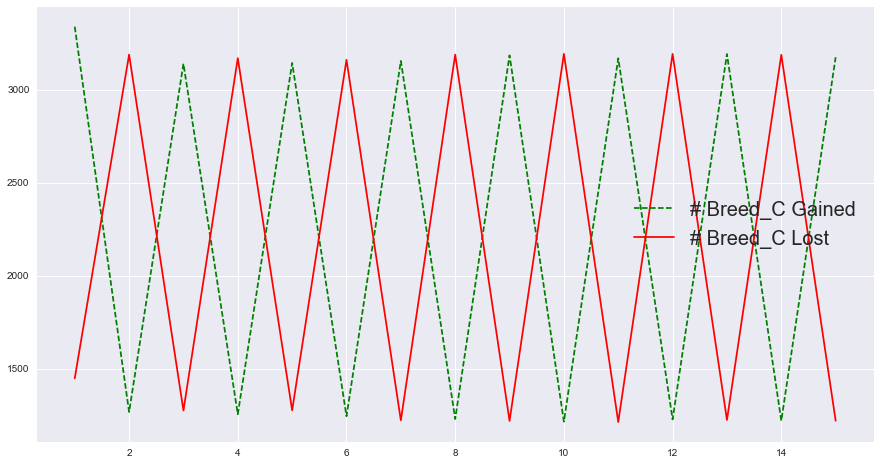

In [383]:
dataFilePath = "C:/Users/Nazariy/Desktop/Simudyne_Backend_Test.csv"
saveFilePath = "C:/Users/Nazariy/Desktop/Simudyne_Bacend_Test_Output.csv"
lb_BrandFactor = 0.1
ub_BrandFactor = 2.9

inputData     = processInputData(dataFilePath)
inputDataSize = len(inputData) 

start = time.time()
runModel(generateBrandFactorVector(lb_BrandFactor,ub_BrandFactor,inputDataSize),inputData)
end   = time.time()

print "It took: " + "{0:.4f}".format((end-start)*1000.0) + " miliseconds."

modelOutput()                           # Breed_C_Gained and Breed_C_Lost
inputData.to_csv(saveFilePath,index=False) # Breed C and NC agents are in the file saved.